# Import Required Libraries
Import necessary libraries for data manipulation such as pandas, numpy, and json.

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np 
import json
from bao import *   # author self-developed library
from functions import * # author self-developed library

# <center> Load and Explore CIC Data
Load the CIC data from files and explore its structure to understand the nested format.

In [2]:
df = pd.read_excel('./1. Professional Test.xlsx', engine='calamine', sheet_name='Dataset')

##  <center> Check duplicates for id

In [3]:
id=['customer_id', 'disbursement_date']
df[id].drop_duplicates().shape
df.shape

(14000, 2)

(14000, 77)

In [4]:
df.set_index(id, inplace=True)
# Apply the parsing function to each row in the CIC_DATA column
parsed_data = []
for i, row in df.iterrows():
    json_str = row['CIC_DATA']
    out = parse_row_cic(json_str)
    parsed_data.append(out)
# Create the dataframe after processing all rows
cic_df = pd.DataFrame(parsed_data, index=df.index)

In [5]:
# Apply the function to count unique search code values
cic_df = process_columns(cic_df,aggregrate_input,function_mapping)

df=df.merge(cic_df, how='left', left_index=True, right_index=True)

In [6]:
# parquet is better faster, but excel is more readable
df.to_excel('./full_data.xlsx', index=True)

In [7]:
for i in df.columns:
    try:
        df[i] = df[i].astype('float')
    except:
        continue

# Distribution Analysis of First Payment Default (FPD10+)

This section analyzes the distribution of First Payment Default after 10+ days (FPD10+), which is a key metric for loan performance. Understanding the distribution of FPD10+ helps assess default risk patterns in our dataset.

We'll examine:
- The overall distribution of FPD10+ values
- Convert this metric into a binary classification target (defaulted vs non-defaulted)
- Use this binary target for subsequent predictive modeling

The binary classification approach (defining defaults as FPD10+ > 0) allows us to build models that can effectively predict the likelihood of customer defaults.

<Figure size 1400x800 with 0 Axes>

<Axes: >

<Axes: xlabel='FPD10+', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of First Payment Default (FPD10+)')

Text(0.5, 0, 'FPD10+ Value')

Text(0, 0.5, 'Frequency')

<Axes: >

<Axes: xlabel='FPD10+'>

Text(0.5, 1.0, 'Box Plot of FPD10+ Values')

Text(0.5, 0, 'FPD10+ Value')

FPD10+ Statistics:
Count: 14000
Mean: 1.74
Median: 0.00
Standard Deviation: 3.41
Min: 0.00
Max: 10.00

Default Rate (FPD10+ > 0): 33.69%


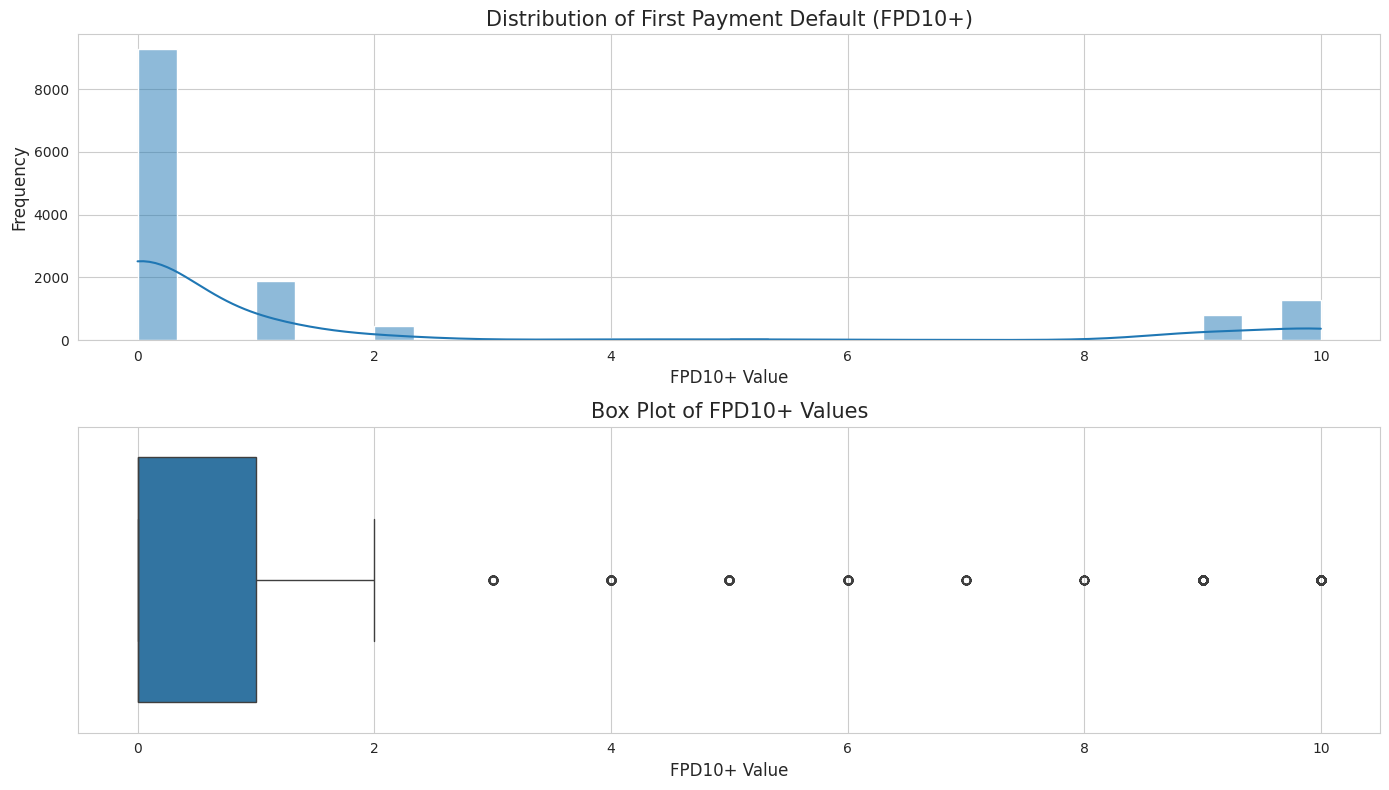

In [8]:
import seaborn as sns

import matplotlib.pyplot as plt

# Set figure size and style
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# Create a layout with two plots
plt.subplot(2, 1, 1)
# Histogram with KDE
sns.histplot(df['FPD10+'], kde=True, bins=30)
plt.title('Distribution of First Payment Default (FPD10+)', fontsize=15)
plt.xlabel('FPD10+ Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.subplot(2, 1, 2)
# Box plot to show outliers
sns.boxplot(x=df['FPD10+'])
plt.title('Box Plot of FPD10+ Values', fontsize=15)
plt.xlabel('FPD10+ Value', fontsize=12)

plt.tight_layout()

# Display statistics about the distribution
print(f"FPD10+ Statistics:")
print(f"Count: {df['FPD10+'].count()}")
print(f"Mean: {df['FPD10+'].mean():.2f}")
print(f"Median: {df['FPD10+'].median():.2f}")
print(f"Standard Deviation: {df['FPD10+'].std():.2f}")
print(f"Min: {df['FPD10+'].min():.2f}")
print(f"Max: {df['FPD10+'].max():.2f}")
print(f"\nDefault Rate (FPD10+ > 0): {(df['FPD10+'] > 0).mean()*100:.2f}%")

> FPD10+ highly skew to the left, hence, it should be 0 FPD10+ would be classified non-default and other is default

In [9]:
# # Create binary target for classification (1 if FPD10+ > 0, else 0)
# df['binary_label'] = 0
# df.loc[df['FPD10+'] > 0, 'binary_label'] = 1

# # Check the distribution of the new binary label
# print(df['binary_label'].value_counts())


In [10]:
X_train, X_test, y_train, y_test = split_data(
    df.drop(columns=['CIC_DATA','DONG','MOTA_XEPHANGKH','TTKHAC','SL_TCTD','SL_TSDB','MOTA_TSDB','gender','occupation','address_apply','operating_system','phone_provider','DPD10_3MOB','NGAYCHAM']),
    target_column='FPD10+',  # Change this if your target column has a different name
    test_size=0.2,
    random_state=42,
    max_ratio=0.5,
    rebalance=False# Ensures no category exceeds 50% in either split
)

Original data distribution:
FPD10+
0.0     0.663071
1.0     0.135000
10.0    0.091643
9.0     0.057214
2.0     0.031643
5.0     0.006214
4.0     0.005714
6.0     0.003429
3.0     0.002786
7.0     0.001929
8.0     0.001357
Name: proportion, dtype: float64

Some categories exceed 50.0% in split, but rebalancing is disabled.

Final train set distribut ion:
FPD10+
0.0     0.663036
1.0     0.135000
10.0    0.091607
9.0     0.057232
2.0     0.031696
5.0     0.006250
4.0     0.005714
6.0     0.003393
3.0     0.002768
7.0     0.001964
8.0     0.001339
Name: proportion, dtype: float64

Final test set distribution:
FPD10+
0.0     0.663214
1.0     0.135000
10.0    0.091786
9.0     0.057143
2.0     0.031429
5.0     0.006071
4.0     0.005714
6.0     0.003571
3.0     0.002857
7.0     0.001786
8.0     0.001429
Name: proportion, dtype: float64

Note: Some categories exceed 50.0% in train or test set
Categories exceeding in train: [0.0]
Categories exceeding in test: [0.0]


In [11]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
scale=StandardScaler()

In [12]:
X = df.drop(['CIC_DATA','DONG','MOTA_XEPHANGKH','TTKHAC','SL_TCTD','SL_TSDB','MOTA_TSDB','gender','occupation','address_apply','operating_system','phone_provider','DPD10_3MOB','NGAYCHAM'], axis=1)
y = df['FPD10+']
labeling= LabelEncoder()
y= labeling.fit_transform(y)
scaling=StandardScaler()
X= scaling.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_eval, y_train, y_eval = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

In [13]:
best_model=train_xgboost(X_train,y_train, X_eval , y_eval,y)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV 2/10] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.5;, score=1.000 total time=  15.5s
[CV 9/10] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=300, subsample=0.5;, score=0.999 total time=  15.7s
[CV 2/10] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=300, subsample=0.5;, score=1.000 total time=  15.7s
[CV 1/10] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.5;, score=0.999 total time=  15.8s
[CV 4/10] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=300, subsample=0.5;, score=0.999 total time=  15.8s
[CV 3/10] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=300, 

<BarContainer object of 20 artists>

([<matplotlib.axis.YTick at 0x7febf5fcda30>,
 [Text(0, 0, 'SHORT_TERM_AMOUNT'),
  Text(0, 1, 'OUTS_BAL_LOAN_M7'),
  Text(0, 2, 'NHOM2_12THANG_TONGDUNO_max'),
  Text(0, 3, 'MID_TERM_COUNT'),
  Text(0, 4, 'QHTD_TONG_VND_mean'),
  Text(0, 5, 'OUTS_BAL_ALL_M6'),
  Text(0, 6, 'NOXAU_60THANG_NOXAU_VND_sum'),
  Text(0, 7, 'QHTD_TONG_VND_max'),
  Text(0, 8, 'OUTS_BAL_ALL_M1'),
  Text(0, 9, 'OUTS_BAL_LOAN_M6'),
  Text(0, 10, 'MID_TERM_COUNT_BANK'),
  Text(0, 11, 'OUTS_BAL_CC_M8'),
  Text(0, 12, 'QHTD_CTLOAIVAY_NHOM1_USD_min'),
  Text(0, 13, 'OUTS_BAL_LOAN_M8'),
  Text(0, 14, 'DUNO_THETD_HANMUC_THETD_min'),
  Text(0, 15, 'NOXAU_60THANG_NOXAU_VND_mean'),
  Text(0, 16, 'OUTS_BAL_CC_CURRENT'),
  Text(0, 17, 'OUTS_BAL_LOAN_M1'),
  Text(0, 18, 'NUM_NEW_LOAN_12M'),
  Text(0, 19, 'DUNO_VAMC')])

Text(0.5, 0, 'Feature Importance Score')

Text(0, 0.5, 'Features')

Text(0.5, 1.0, 'XGBoost Feature Importance')

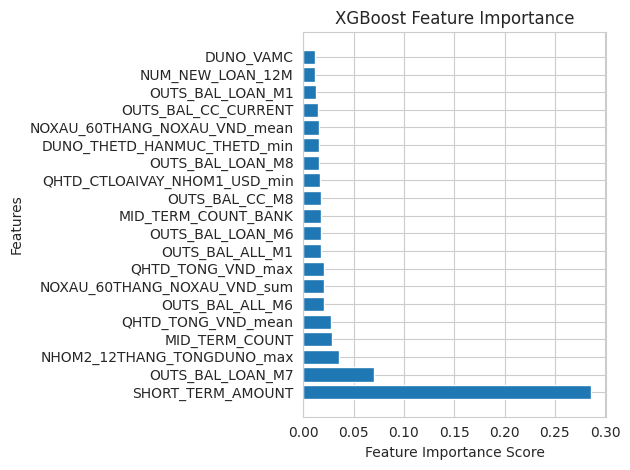


Top 10 Most Important Features:
1. SHORT_TERM_AMOUNT: 0.2863
2. OUTS_BAL_LOAN_M7: 0.0703
3. NHOM2_12THANG_TONGDUNO_max: 0.0354
4. MID_TERM_COUNT: 0.0284
5. QHTD_TONG_VND_mean: 0.0271
6. OUTS_BAL_ALL_M6: 0.0207
7. NOXAU_60THANG_NOXAU_VND_sum: 0.0206
8. QHTD_TONG_VND_max: 0.0203
9. OUTS_BAL_ALL_M1: 0.0173
10. OUTS_BAL_LOAN_M6: 0.0173


In [14]:
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
# Get feature names if available, otherwise use indices
try:
    # Try to get original feature names before StandardScaler
    feature_names = df.drop(['CIC_DATA','DONG','MOTA_XEPHANGKH','TTKHAC',
                            'SL_TCTD','SL_TSDB','MOTA_TSDB','gender',
                            'occupation','address_apply','operating_system',
                            'phone_provider','DPD10_3MOB','NGAYCHAM', 'FPD10+'], axis=1).columns
except:
    feature_names = [f'feature_{i}' for i in range(len(importances))]

# Plot top 20 features for better readability
n_features_to_plot = min(20, len(importances))
plt.barh(range(n_features_to_plot), importances[indices[:n_features_to_plot]])
plt.yticks(range(n_features_to_plot), [feature_names[i] for i in indices[:n_features_to_plot]])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()
print("\nTop 10 Most Important Features:")
for i in range(min(10, len(indices))):
    print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

Accuracy: 0.7980

Classification Report:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      5569
           1       1.00      1.00      1.00      1134
           2       0.00      0.00      0.00       266
           3       0.00      0.00      0.00        23
           4       0.00      0.00      0.00        48
           5       0.00      0.00      0.00        53
           6       0.00      0.00      0.00        29
           7       0.00      0.00      0.00        16
           8       0.00      0.00      0.00        11
           9       0.00      0.00      0.00       481
          10       0.00      0.00      0.00       770

    accuracy                           0.80      8400
   macro avg       0.16      0.18      0.17      8400
weighted avg       0.64      0.80      0.71      8400



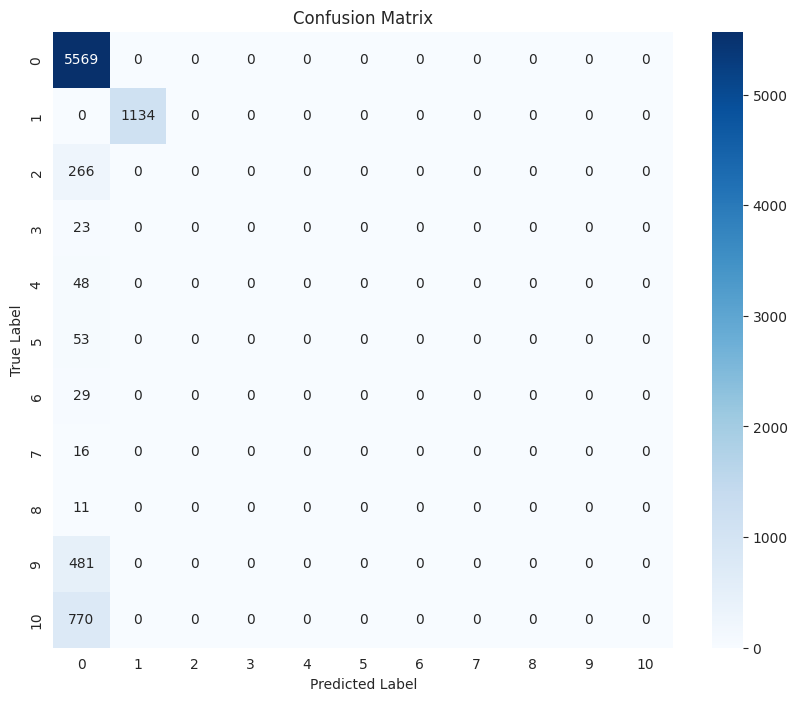


Model Quality Metrics:
AUC: 1.0000
Gini Coefficient: 1.0000


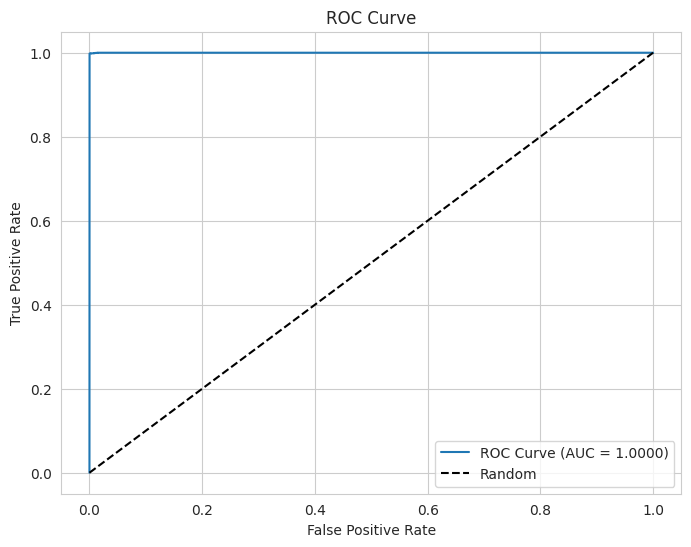

<Figure size 1200x1000 with 0 Axes>

In [15]:
summa_xgboost(best_model, X_train, y_train)

Accuracy: 0.7982

Classification Report:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      1857
           1       1.00      1.00      1.00       378
           2       0.00      0.00      0.00        88
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00        16
           5       0.00      0.00      0.00        17
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00       160
          10       0.00      0.00      0.00       257

    accuracy                           0.80      2800
   macro avg       0.16      0.18      0.17      2800
weighted avg       0.64      0.80      0.71      2800



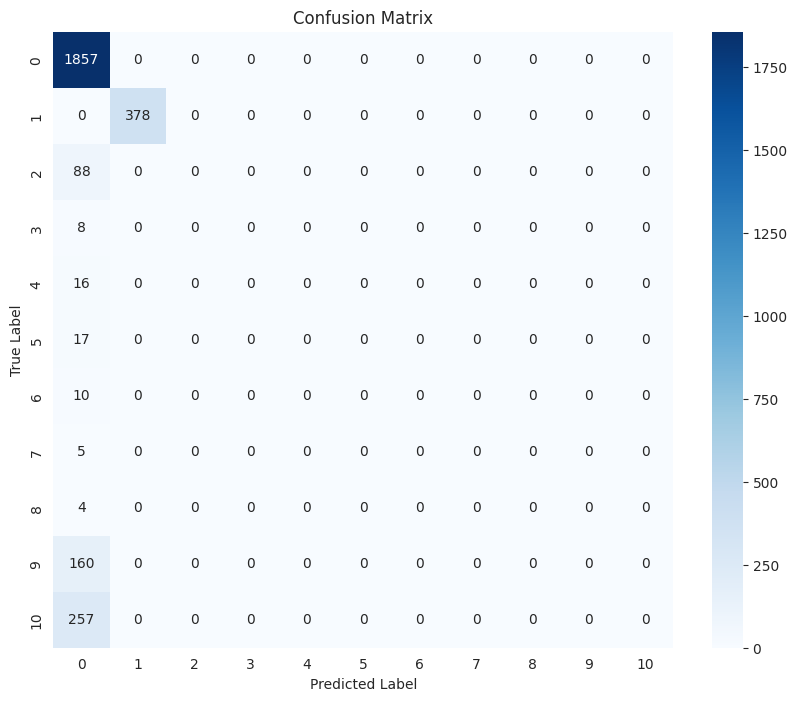


Model Quality Metrics:
AUC: 1.0000
Gini Coefficient: 1.0000


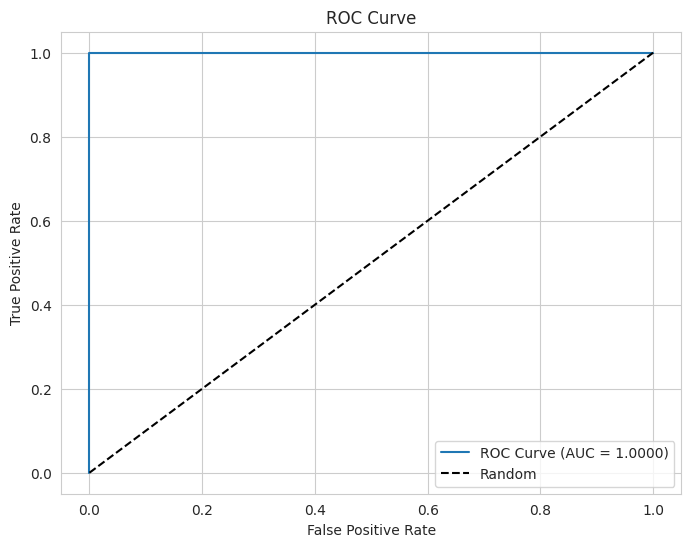

<Figure size 1200x1000 with 0 Axes>

In [16]:
summa_xgboost(best_model, X_test, y_test)